<a href="https://colab.research.google.com/github/DRodriguez615/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
df

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49347,1.0,2,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,medium,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,low,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# first new feature = total rooms
df['Total Rooms'] = df['bathrooms'] + df['bedrooms']
df['Total Rooms']

0        4.5
1        3.0
2        2.0
3        2.0
4        5.0
        ... 
49347    3.0
49348    2.0
49349    2.0
49350    1.0
49351    3.0
Name: Total Rooms, Length: 48817, dtype: float64

In [23]:
# second feature = total perks
df['Total Perks'] = df['elevator'] + df['cats_allowed'] + df['hardwood_floors'] + df['dogs_allowed'] + df['doorman'] + df['dishwasher'] + df['no_fee'] + df['laundry_in_building']
+ df['fitness_center'] + df['pre-war'] + df['laundry_in_unit'] + df['roof_deck'] + df['outdoor_space'] + df['dining_room'] + df['high_speed_internet'] + df['balcony'] + df['swimming_pool']
+ df['new_construction'] + df['terrace'] + df['exclusive'] + df['loft'] + df['garden_patio'] + df['wheelchair_access'] + df['common_outdoor_space']
df['Total Perks']

0        0
1        4
2        3
3        2
4        0
        ..
49347    4
49348    5
49349    4
49350    4
49351    1
Name: Total Perks, Length: 48817, dtype: int64

In [9]:
df

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,Total Rooms,Date,year,month,Total Perks
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,2016-06-24 07:54:24,2016,6,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,2016-06-12 12:19:27,2016,6,4
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2016-04-17 03:26:41,2016,4,3
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2016-04-18 02:22:02,2016,4,2
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,2016-04-28 01:32:41,2016,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49347,1.0,2,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,medium,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,2016-06-02 05:41:05,2016,6,4
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,low,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,2.0,2016-04-04 18:22:34,2016,4,5
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2016-04-16 02:13:40,2016,4,4
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2016-04-08 02:13:33,2016,4,4


In [0]:
# # $3,580 a month on averge
# pd.options.display.float_format = '{:,.0f}'.format
# df['price'].describe()

In [6]:
df['Date'] = pd.to_datetime(df['created'])
df['year'], df['month'] = df['Date'].dt.year, df['Date'].dt.month
dates = df.groupby('Date').Date.count()
dates 

Date
2016-04-01 22:12:41    1
2016-04-01 22:56:00    1
2016-04-01 22:57:15    1
2016-04-01 23:26:07    1
2016-04-02 00:48:13    1
                      ..
2016-06-29 17:47:34    1
2016-06-29 17:56:12    1
2016-06-29 18:14:48    1
2016-06-29 18:30:41    1
2016-06-29 21:41:47    1
Name: Date, Length: 48148, dtype: int64

In [0]:
train = df.query('month < 6 ')
test = df.query('month == 6')

In [11]:
print(train.shape, test.shape)

(31844, 39) (16973, 39)


In [13]:
print(train['price'].mean())
print(test['price'].mean())

3575.604007034292
3587.0546750721733


In [0]:
# arranging y target vector
target = 'price'
y_train = train[target]
y_test = test[target]

In [0]:
# mean baseline
guess = y_train.mean()

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
model = LinearRegression()

In [33]:
# setting x features 
features = ['Total Rooms', 'Total Perks']
X_train = train[features]
X_test = test[features]
print(f'Linear Regression, dependent on: {features}')
print(X_train.shape, X_test.shape)

Linear Regression, dependent on: ['Total Rooms', 'Total Perks']
(31844, 2) (16973, 2)


In [38]:
# fit the model
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train Error: {mae:.2f}')

Train Error: 1201.88


In [39]:
# apply to new data
y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test Error: {mae:.2f}')

Test Error: 1201.88


In [0]:
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

def regression_3d(df, x, y, z, num=100, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    num : integer, number of quantiles for each feature
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of coordinates in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    xcoords = np.linspace(xmin, xmax, num)
    ycoords = np.linspace(ymin, ymax, num)
    coords = list(itertools.product(xcoords, ycoords))
    
    # Make predictions for the grid
    predictions = model.predict(coords)
    Z = predictions.reshape(num, num).T
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=xcoords, y=ycoords, z=Z))
    
    return fig

In [0]:
regression_3d(
    train,
    x='Total Rooms', 
    y='Total Perks', 
    z='price', 
    text='price', 
    title='price per rooms/perks'
)

In [42]:
model.intercept_, model.coef_

(913.664040393372, array([781.43287738, 164.12965905]))

In [43]:
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept 913.664040393372
Total Rooms    781.432877
Total Perks    164.129659


In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

Mean Squared Error: 3105028.217891242
Root Mean Squared Error: 1762.1090255404863
Mean Absolute Error: 1201.8811133682555
R^2: 0.0


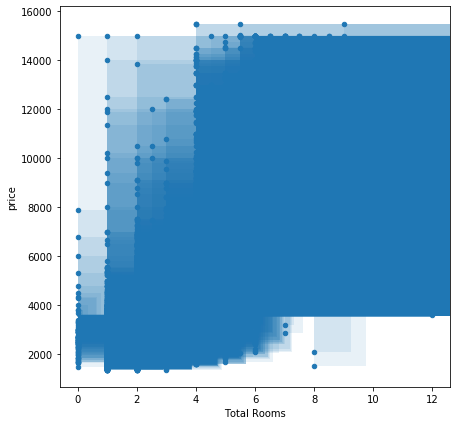

In [48]:
feature = 'Total Rooms'
squared_errors(train, feature, target, m=0, b=y_train.mean())

Mean Squared Error: 3105028.217891242
Root Mean Squared Error: 1762.1090255404863
Mean Absolute Error: 1201.8811133682555
R^2: 0.0


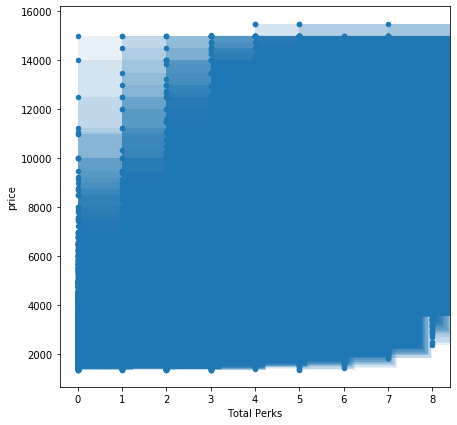

In [50]:
feature = 'Total Perks'
squared_errors(train, feature, target, m=0, b=y_train.mean())

Mean Squared Error: 3108021.267852562
Root Mean Squared Error: 1762.9581015590138
Mean Absolute Error: 1200.8695333832386
R^2: 0.0


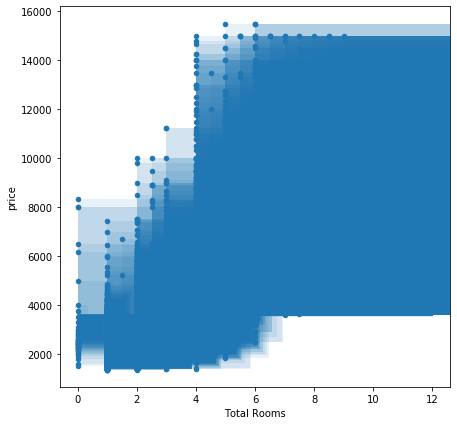

In [49]:
feature = 'Total Rooms'
squared_errors(test, feature, target, m=0, b=y_test.mean())

Mean Squared Error: 3108021.267852562
Root Mean Squared Error: 1762.9581015590138
Mean Absolute Error: 1200.8695333832386
R^2: 0.0


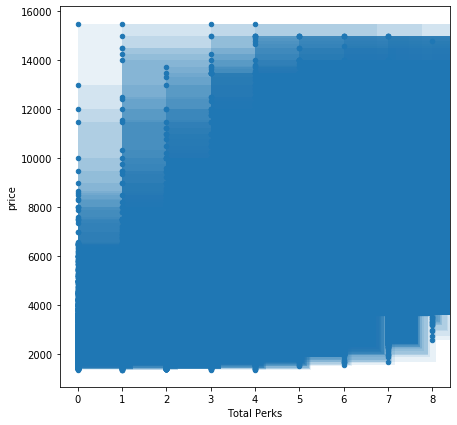

In [51]:
feature = 'Total Perks'
squared_errors(test, feature, target, m=0, b=y_test.mean())

Mean Squared Error: 7473563.44064816
Root Mean Squared Error: 2733.7818933938674
Mean Absolute Error: 2136.614621278734
R^2: -1.406922873545986


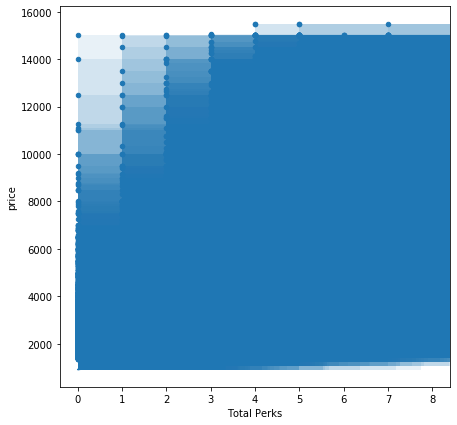

In [58]:
squared_errors(train, feature, target, m=164, b=913)

In [55]:
def add_constant(X):
    constant = np.ones(shape=(len(X),1))
    return np.hstack((constant, X))
X = add_constant(train[features].values)
print('X')
print(X)

# y is a column vector
y = train[target].values[:, np.newaxis]
print('y')
print(y)

# Least squares solution in code
X_transpose = X.T
X_transpose_X = X_transpose @ X
X_transpose_X_inverse = np.linalg.inv(X_transpose_X)
X_transpose_y = X_transpose @ y
beta_hat = X_transpose_X_inverse @ X_transpose_y

print('Beta Hat')
print(beta_hat)

X
[[1. 2. 3.]
 [1. 2. 2.]
 [1. 5. 0.]
 ...
 [1. 2. 4.]
 [1. 1. 4.]
 [1. 3. 1.]]
y
[[2850]
 [3275]
 [3350]
 ...
 [2595]
 [3350]
 [2200]]
Beta Hat
[[913.66404039]
 [781.43287738]
 [164.12965905]]


In [56]:
model.intercept_, model.coef_

(913.664040393372, array([781.43287738, 164.12965905]))